## Contextualized model

Let's check where the context really helps

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets

train_dataset, dev_dataset, test_dataset = load_datasets(add_body=True)


In [2]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

context_model_name = "../models/bert-contextualized-hate-speech-es/"
no_context_model_name = "../models/bert-non-contextualized-hate-speech-es"
full_context_model_name = "../models/bert-title-body-hate-speech-es/"


context_model = AutoModelForSequenceClassification.from_pretrained(context_model_name, return_dict=True, num_labels=2)
no_context_model = AutoModelForSequenceClassification.from_pretrained(no_context_model_name, return_dict=True, num_labels=2)
full_context_model = AutoModelForSequenceClassification.from_pretrained(no_context_model_name, return_dict=True, num_labels=2)

context_model.eval()
no_context_model.eval()
full_context_model.eval()


device = "cuda" if torch.cuda.is_available() else "cpu"

context_model = context_model.to(device)
no_context_model = no_context_model.to(device)
full_context_model = full_context_model.to(device)
# Tienen mismo tokenizer as√≠ que todo bien

no_context_tokenizer = AutoTokenizer.from_pretrained(no_context_model_name)
context_tokenizer = AutoTokenizer.from_pretrained(context_model_name)
full_context_tokenizer = AutoTokenizer.from_pretrained(context_model_name)

no_context_tokenizer.model_max_length = 128
context_tokenizer.model_max_length = 256

In [9]:
from hatedetection.training import tokenize

batch_size = 32
eval_batch_size = 16

dataset = test_dataset


no_context_dataset = dataset.map(lambda x: tokenize(no_context_tokenizer, x, context='none'), batched=True, batch_size=eval_batch_size)
context_dataset = dataset.map(lambda x: tokenize(context_tokenizer, x, context='title'), batched=True, batch_size=eval_batch_size)
full_context_dataset = dataset.map(lambda x: tokenize(full_context_tokenizer, x, context='title+body'), batched=True, batch_size=eval_batch_size)


In [10]:

def format_dataset(dataset):
    dataset = dataset.map(lambda examples: {'labels': examples['HATEFUL']})
    dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
    return dataset

no_context_dataset = format_dataset(no_context_dataset)
context_dataset = format_dataset(context_dataset)
full_context_dataset = format_dataset(full_context_dataset)


Lo cargamos s√≥lo para evaluar ü§ó

In [11]:
from hatedetection.metrics import compute_hate_metrics
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=".",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
)


context_trainer = Trainer(
    model=context_model,
    args=training_args,
    compute_metrics=compute_hate_metrics,
)

full_context_trainer = Trainer(
    model=full_context_model,
    args=training_args,
    compute_metrics=compute_hate_metrics,
)

no_context_trainer = Trainer(
    model=no_context_model,
    args=training_args,
    compute_metrics=compute_hate_metrics,
)


## Resultados

In [12]:
import pandas as pd
pd.options.display.max_columns = 40
pd.set_option('display.float_format', lambda x: '%.5f' % x)


df_full_context_results = pd.DataFrame([full_context_trainer.evaluate(full_context_dataset)])
df_context_results = pd.DataFrame([context_trainer.evaluate(context_dataset)])
df_no_context_results = pd.DataFrame([no_context_trainer.evaluate(no_context_dataset)])


In [ ]:
df_results = pd.concat([df_no_context_results, df_context_results, df_full_context_results])
df_results["index"] = ["No context", "Title", "Title and Body"]
df_results.set_index("index")

## Dev Results

In [8]:
df_results = pd.concat([df_no_context_results, df_context_results, df_full_context_results])
df_results["index"] = ["No context", "Title", "Title and Body"]
df_results.set_index("index")

eval_loss  eval_accuracy  eval_f1  eval_macro_f1  \
index                                                              
No context        0.50128        0.90753  0.66980        0.80802   
Title             0.60040        0.92554  0.73883        0.84771   
Title and Body    0.85207        0.86130  0.18778        0.55598   

                eval_precision  eval_recall  eval_runtime  \
index                                                       
No context             0.73431      0.61572      38.45080   
Title                  0.79322      0.69142      76.05850   
Title and Body         0.86905      0.10526     156.20100   

                eval_samples_per_second  init_mem_cpu_alloc_delta  \
index                                                               
No context                    236.82200                     43460   
Title                         119.72400                     52465   
Title and Body                 58.29700                     43325   

                init_mem_gpu_alloc_delta  init_mem_cpu_peaked_delta  \
index                                                                 
No context                             0                      18258   
Title                                  0                      18258   
Title and Body                         0                      18258   

                init_mem_gpu_peaked_delta  eval_mem_cpu_alloc_delta  \
index                                                                 
No context                              0                    200737   
Title                                   0                    209357   
Title and Body                          0                    430762   

                eval_mem_gpu_alloc_delta  eval_mem_cpu_peaked_delta  \
index                                                                 
No context                             0                     755193   
Title                                  0                     756777   
Title and Body                         0                     742281   

                eval_mem_gpu_peaked_delta  
index                                      
No context                       69447680  
Title                           189042688  
Title and Body                  579227648

In [8]:
df_results = pd.concat([df_no_context_results, df_context_results, df_full_context_results])
df_results["index"] = ["No context", "Title", "Title and Body"]
df_results.set_index("index")

eval_loss  eval_accuracy  eval_f1  eval_macro_f1  \
index                                                              
No context        0.55797        0.90655  0.67655        0.81097   
Title             0.59812        0.92335  0.73174        0.84351   
Title and Body    0.81184        0.86448  0.26722        0.59628   

                eval_precision  eval_recall  eval_runtime  \
index                                                       
No context             0.71543      0.64167      38.28570   
Title                  0.78354      0.68637      75.95080   
Title and Body         0.75758      0.16222     156.60900   

                eval_samples_per_second  init_mem_cpu_alloc_delta  \
index                                                               
No context                    237.84300                     44493   
Title                         119.89300                     55218   
Title and Body                 58.14500                     44358   

                init_mem_gpu_alloc_delta  init_mem_cpu_peaked_delta  \
index                                                                 
No context                             0                      18258   
Title                                  0                      18258   
Title and Body                         0                      18258   

                init_mem_gpu_peaked_delta  eval_mem_cpu_alloc_delta  \
index                                                                 
No context                              0                    198682   
Title                                   0                    213028   
Title and Body                          0                    428073   

                eval_mem_gpu_alloc_delta  eval_mem_cpu_peaked_delta  \
index                                                                 
No context                             0                     754465   
Title                                  0                     756649   
Title and Body                         0                     742209   

                eval_mem_gpu_peaked_delta  
index                                      
No context                       69447680  
Title                           189042688  
Title and Body                  579227648

In [8]:
df_results = pd.concat([df_no_context_results, df_context_results, df_full_context_results])
df_results["index"] = ["No context", "Title", "Title and Body"]
df_results.set_index("index")

eval_loss  eval_accuracy  eval_f1  eval_macro_f1  \
index                                                              
No context        0.55797        0.90655  0.67655        0.81097   
Title             0.59812        0.92335  0.73174        0.84351   
Title and Body    0.81184        0.86448  0.26722        0.59628   

                eval_precision  eval_recall  eval_runtime  \
index                                                       
No context             0.71543      0.64167      37.81200   
Title                  0.78354      0.68637      68.17460   
Title and Body         0.75758      0.16222     162.51570   

                eval_samples_per_second  init_mem_cpu_alloc_delta  \
index                                                               
No context                    240.82300                     44493   
Title                         133.56900                     55162   
Title and Body                 56.03100                     44358   

                init_mem_gpu_alloc_delta  init_mem_cpu_peaked_delta  \
index                                                                 
No context                             0                      18258   
Title                                  0                      18258   
Title and Body                         0                      18258   

                init_mem_gpu_peaked_delta  eval_mem_cpu_alloc_delta  \
index                                                                 
No context                              0                    196610   
Title                                   0                    427754   
Title and Body                          0                    211508   

                eval_mem_gpu_alloc_delta  eval_mem_cpu_peaked_delta  \
index                                                                 
No context                             0                     756169   
Title                                  0                     742337   
Title and Body                         0                     756361   

                eval_mem_gpu_peaked_delta  
index                                      
No context                       69447680  
Title                           189042688  
Title and Body                  579227648

## Error Analysis

In [11]:
context_prediction = context_trainer.predict(context_dataset)
no_context_prediction = no_context_trainer.predict(no_context_dataset)

In [12]:
context_prediction.predictions.argmax(axis=1).shape

(9106,)

In [13]:
df = context_dataset.to_pandas()
df.drop(["token_type_ids", "attention_mask"], axis=1, inplace=True)


df["context_pred"] = context_prediction.predictions.argmax(axis=1)
df["no_context_pred"] = no_context_prediction.predictions.argmax(axis=1)

df.set_index("id", inplace=True)

df

APPEARANCE  CALLS  CLASS  CRIMINAL  DISABLED  HATEFUL  LGBTI  \
id                                                                     
337647           0      0      0         0         0        0      0   
336499           0      0      0         0         0        0      0   
387046           0      0      0         0         0        0      0   
350341           0      0      0         0         0        0      0   
336008           0      0      0         0         0        0      0   
...            ...    ...    ...       ...       ...      ...    ...   
331427           0      0      0         0         0        0      0   
355482           0      0      0         0         0        0      0   
400833           0      0      0         0         0        0      0   
360086           0      0      0         0         0        0      0   
338779           0      0      0         0         0        0      0   

        POLITICS  RACISM  WOMEN  \
id                                
337647         0       0      0   
336499         0       0      0   
387046         0       0      0   
350341         0       0      0   
336008         0       0      0   
...          ...     ...    ...   
331427         0       0      0   
355482         0       0      0   
400833         0       0      0   
360086         0       0      0   
338779         0       0      0   

                                                input_ids  labels  \
id                                                                  
337647  [4, 1005, 30966, 5021, 4792, 1039, 1346, 1009,...       0   
336499  [4, 20828, 16527, 13397, 995, 1100, 2926, 2150...       0   
387046  [4, 1120, 1507, 30966, 14319, 30957, 1057, 126...       0   
350341  [4, 1039, 4537, 2038, 6371, 1053, 5168, 1081, ...       0   
336008  [4, 15885, 29559, 3568, 1054, 26487, 1431, 995...       0   
...                                                   ...     ...   
331427  [4, 8695, 1600, 1098, 998, 30956, 1008, 3547, ...       0   
355482  [4, 1039, 24564, 8815, 4202, 1009, 19948, 1137...       0   
400833  [4, 1724, 1048, 1389, 1328, 1097, 1041, 5047, ...       0   
360086  [4, 1369, 13596, 1095, 4256, 1301, 22373, 1069...       0   
338779  [4, 1032, 15858, 3431, 1041, 1039, 8132, 10791...       0   

                                                     text  \
id                                                          
337647                                 [USER] Que cinismo   
336499  [USER] La sociedad les dio la espalda en 2019 ...   
387046  [USER] Revolucionario ponerse en bolas? Uy s√≠,...   
350341  [USER] Como??..si deberia estar en la CARCEL c...   
336008  [USER] Seamos serios si en la Pcia de Cornejo ...   
...                                                   ...   
331427  [USER] Este pibe no puede m√°s de pelotudo!!! L...   
355482  [USER] No es un mensaje, todo hay que explicar...   
400833                [USER] Per√≥n, Per√≥n, que grande sos   
360086  [USER] Si hiciste lo correcto seguro te critic...   
338779  [USER] Ahhh ya, ufsss como lo dicen los chanta...   

                                                    title  context_pred  \
id                                                                        
337647  Wuhan celebra el fin de la cuarentena por el c...             0   
336499  Patricia Bullrich: "Somos mirados por la socie...             0   
387046            ¬°Calu Rivero se desnud√≥ para Instagram!             0   
350341  El l√≠der piquetero Luis DEl√≠a pidi√≥ el indulto...             0   
336008  Cristina Kirchner no afloja: le peg√≥ a Horacio...             0   
...                                                   ...           ...   
331427  Banderazo 17A. Juan Grabois pidi√≥ multas para ...             0   
355482  El contundente mensaje de Noelia Marzol sobre ...             0   
400833  Acuerdo con Putin para que Rusia instale una b...             0   
360086  Graciela Cama√±o defendi√≥ su voto en el Consejo...             0   
338779  La

In [14]:
sum(df["context_pred"] != df["no_context_pred"])

643

Hagamos un barplot de la performance de la detecci√≥n para cada categor√≠a

- Para categor√≠a C, me fijo la recall de cada clasificador en esa categor√≠a

Ojo que es distinto que la tarea de categorizaci√≥n



In [16]:
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 400

df[(df["DISABLED"] != 0) & (df["no_context_pred"] == 0)][["title", "text", "no_context_pred", "context_pred", "labels", "DISABLED"]]

title  \
id                                                                                                                                                             
333926                Calu Rivero, desnuda en una playa de Estados Unidos, reflexion√≥ sobre la libertad y el empoderamiento de las mujeres a trav√©s del arte   
362143                       Un grupo de encapuchados saque√≥ una tienda de Louis Vuitton en Portland en medio de las protestas por la muerte de George Floyd   
377207                                                                  Eduardo Duhalde: "Mi impresi√≥n es que Alberto Fern√°ndez est√° grogui, como De la R√∫a"   
384261                                                                      Carri√≥ dice que el gobierno usa la pandemia para "establecer un estado de sitio"   
394030                                                                Nicol√°s Kreplak: "Alg√∫n sector de clase alta es muy reticente a seguir las normativas"   
384257                                                                      Carri√≥ dice que el gobierno usa la pandemia para "establecer un estado de sitio"   
371393                                            Claribel Medina, enojada con un grupo de gente reunida en un bar: "¬øPor qu√© para unos s√≠ y para otros no?"   
332353                                                              El mensaje de Florencia Kirchner antes de volver a la Argentina: "Tengo l√°grimas negras"   
330665                                                                            En pandemia, Mayra Mendoza despleg√≥ una colecci√≥n de "barbijos militantes"   
399061                                                    Fuerte cruce entre √örsula Vargues y Horacio Cabak: "Cipayo vende humo", "¬øTe golpeaste la cabeza?"   
361720                         Juan Grabois volvi√≥ a justificar las tomas de tierras: "Es una situaci√≥n delictiva de gente que no tiene intenci√≥n delictiva"   
384001      Fuerte mensaje de la jefa de Emergencias del Hospital Posadas: "Necesitamos que entiendan que el sistema y el personal est√°n cerca de su l√≠mite"   
360301                                                       El divertido pedido de Jimena Bar√≥n a Alberto Fern√°ndez por la falta de intimidad en cuarentena   
350717                                                                              Susana Gim√©nez: "Tengo terror de que nos quieran convertir en Venezuela"   
404668                                             Senadores kirchneristas proponen que la mitad de los nuevos billetes de $1.000 tengan la cara de Maradona   
333885                Calu Rivero, desnuda en una playa de Estados Unidos, reflexion√≥ sobre la libertad y el empoderamiento de las mujeres a trav√©s del arte   
389475                                                                        Gin√©s Gonz√°lez Garc√≠a: "Le tengo mucho miedo al verano, el riesgo va a seguir"   
355583  Luis Brandoni cruz√≥ a Ricardo Alfons√≠n por sus cr√≠ticas a la marcha: "No est√° en el centro de sus convicciones, de lo que ha mamado desde que naci√≥"   
354351                                                         Morena Rial revel√≥ c√≥mo hizo para descubrir la clave del celular de su ex, Facundo Ambrosioni   
397763                                                    Patricia Bullrich pidi√≥ ser dr√°sticos con los docentes: "El que no va, tendr√° que ser reemplazado"   
357276                                                         Juan Grabois propuso que se multe a los manifestantes del 17A: "Hay que aplicar la autoridad"   
399030                                                  Fuerte cruce entre Flavio Mendoza y Victoria Donda: "Es muy f√°cil hablar cuando uno cobra un sueldo"   
358473                                                                 El dif√≠cil presente de Mirta Wons: "No tengo ahorros, los actores estamos en la lona"   
352559       Coronavirus. Gin√©s Gonz√°lez Garc√≠a: "Con Mauricio Macri no me enojo, nunca le importaron lo

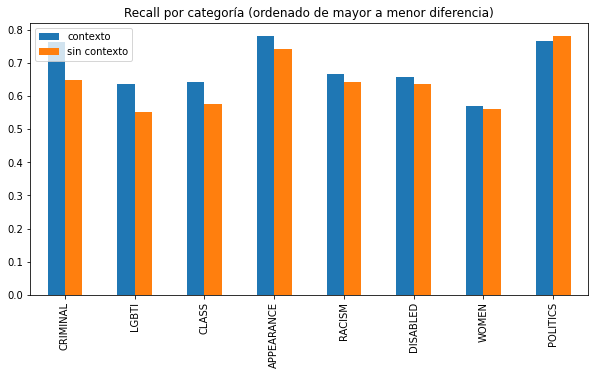

In [17]:
from hatedetection import extended_hate_categories, hate_categories
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt

df_cat_score = pd.DataFrame()

for category in hate_categories:
    cat_df = df[df[category] > 0]
    # Son todos 1s
    labels = cat_df["labels"]
    context_score = recall_score(labels, cat_df["context_pred"])
    no_context_score = recall_score(labels, cat_df["no_context_pred"])
    
    df_cat_score.loc[category, "contexto"] = context_score
    df_cat_score.loc[category, "sin contexto"] = no_context_score


# Ordenamos por diff
df_cat_score["diff"] = df_cat_score["contexto"] - df_cat_score["sin contexto"]
df_cat_score = df_cat_score.sort_values("diff", ascending=False)


df_cat_score.loc[:, ["contexto", "sin contexto"]].plot(kind="bar", title="Recall por categor√≠a (ordenado de mayor a menor diferencia)", figsize=(10, 5))

plt.savefig("recall_category.png")

In [85]:
df_cat_score

contexto  sin contexto     diff
CRIMINAL     0.79200       0.61600  0.17600
LGBTI        0.68939       0.59091  0.09848
CLASS        0.63636       0.55303  0.08333
RACISM       0.68246       0.61848  0.06398
APPEARANCE   0.77778       0.72963  0.04815
WOMEN        0.56221       0.52535  0.03687
DISABLED     0.65882       0.62353  0.03529
POLITICS     0.74439       0.75336 -0.00897

<AxesSubplot:title={'center':'Recall por categor√≠a (ordenado de mayor a menor diferencia)'}>

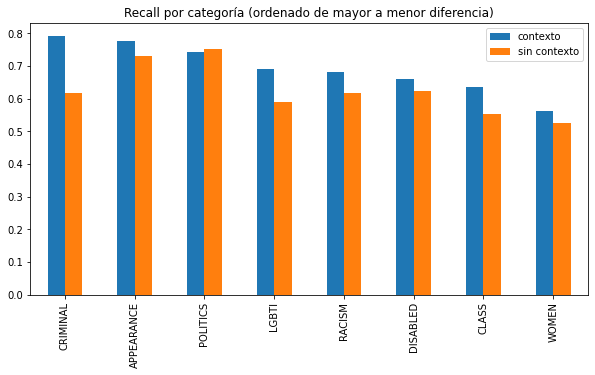

In [92]:
df_cat_score.loc[:, ["contexto", "sin contexto"]].sort_values("contexto", ascending=False).plot(
    kind="bar", title="Recall por categor√≠a (ordenado de mayor a menor diferencia)", figsize=(10, 5),
)

## On hateful messages

In [20]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 300

mismatches = df[df["context_pred"] != df["no_context_pred"]]

hateful = mismatches[mismatches["labels"] > 0]

not_hateful = mismatches[mismatches["labels"] == 0]

hateful[["context", "text", "context_pred", "no_context_pred", "labels"]].sort_values("no_context_pred", ascending=False)

context  \
id                                                                                                                                                                   
371545                                                                          Ernestina Pais no se dio cuenta de que estaba en c√°mara e insult√≥ a Ceferino Reato   
400793                                                                Hist√≥rico: Mara G√≥mez fue habilitada y ser√° la primera jugadora trans en el f√∫tbol argentino   
393930                                               Pablo Duggan se cas√≥ con Karen, su novia venezolana: "Estoy muy feliz de haberla conocido, me cambi√≥ la vida"   
391462                                         Cient√≠ficos argentinos se√±alaron que es casi imposible que carne exportada a China llegue a destino con coronavirus   
375446                La declaraci√≥n de un testigo del caso del jubilado que mat√≥ a un ladr√≥n: "Levantaba la mano pidiendo ayuda y el hombre le volvi√≥ a disparar"   
341105  Un asesor de Donald Trump acus√≥ a China de usar viajeros para propagar el coronavirus: "Los enviaron en aviones a Mil√°n, Nueva York y alrededor del mundo"   
367467                                         Los pesqueros chinos est√°n poniendo en riesgo la supervivencia de diversas especies animales en las islas Gal√°pagos   
378823                                                                                        "¬øQu√© es un look Plus Size? ¬øEl nuevo eufemismo para decir 'gorda'?"   
364203                                        Diego Maradona les responde a sus hijas: "Dalma y Gianinna eligieron estar con quien no es un buen ejemplo de madre"   
357142                                                                  Mar√≠a O'Donnell: "Que la gente se tranquilice porque puede sacar los d√≥lares de su cuenta"   
403207                                                                 La historia de Danny Wakefield: "Soy trans masculino y acabo de dar a luz a mi primer hijo"   
339449                                                       Espa√±a devolvi√≥ por segunda vez un lote de pruebas de coronavirus de China que resultaron defectuosas   
372921                                                           Fuertes cr√≠ticas a la revista Caras por el t√≠tulo de su portada con la hija de M√°xima Zorreguieta   
344222                                  Coronavirus en Argentina: un dirigente radical dese√≥ que la pandemia "haga una limpieza √©tnica" con "negros de La Matanza"   
397990                                       Lali Esp√≥sito fue sorprendida a los besos con un director espa√±ol, a un mes y medio de separarse de Santiago Mocorrea   
336459                                                      Se cur√≥ del coronavirus, volvi√≥ a trabajar y lo apu√±alaron al robarle la plata que ahorr√≥ para su hija   
364777                                                     El Gobierno promueve un acercamiento tecnol√≥gico y financiero con China que sorprendi√≥ a la Casa Blanca   
338856                                     China dice haber desarrollado "con √©xito" la vacuna contra el coronavirus y se prepara para su producci√≥n a gran escala   
367317                                      IFE: el Gobierno analiza mantener el bono de $10.000 de ANSeS para los sectores m√°s vulnerables despu√©s de la pandemia   
377469                                                                                       El sensual paseo en moto de Florencia Pe√±a: "Pr√≥xima parada: tu casa"   
333997                                                           Las l√°grimas de Guillermo Andino tras recuperarse de coronavirus: "El miedo es no poder contarla"   
339721                                   Coronavirus: un diario ingl√©s asegura que los mercados chinos siguen vendiendo murci√©lagos y carne de animales dom√©sticos   
391188                                      China sancion√≥ al frigor√≠fico argentino responsable del env√≠o de carne de ex

In [27]:
lgbti_hateful = hateful[hateful["LGBTI"] > 0]

lgbti_hateful[["context", "text", "context_pred", "no_context_pred", "labels"]].sort_values("context_pred")

context  \
id                                                                                                                                            
386430                                                        Tras los comentarios de J.K. Rowling, Emma Watson defendi√≥ al colectivo trans   
334720                                                            Jimena Bar√≥n y una profunda reflexi√≥n: "Si fuera hombre ser√≠a alto macho"   
400793                                         Hist√≥rico: Mara G√≥mez fue habilitada y ser√° la primera jugadora trans en el f√∫tbol argentino   
384518                                                    Santiago Cafiero repudi√≥ el ataque a C5N: "Hay que desarmar el discurso del odio"   
393566                                                            EE.UU.: Biden nomina a una mujer transg√©nero para un puesto de alto nivel   
403207                                          La historia de Danny Wakefield: "Soy trans masculino y acabo de dar a luz a mi primer hijo"   
393930                        Pablo Duggan se cas√≥ con Karen, su novia venezolana: "Estoy muy feliz de haberla conocido, me cambi√≥ la vida"   
333997                                    Las l√°grimas de Guillermo Andino tras recuperarse de coronavirus: "El miedo es no poder contarla"   
401047                            La impactante historia de la tenista trans que hoy es la N 3 de Argentina en la categor√≠a senior femenino   
392557                                       Coronavirus: Luis Novaresio cont√≥ cu√°l es su condici√≥n para aplicarse la vacuna rusa Sputnik V   
406042                                          Era soltero, se sum√≥ a un matrimonio y ahora son una "tr√≠ada": "Estoy enamorado de los dos"   
335774                             Coronavirus en la Argentina: c√≥mo vive Estanislao, el hijo de Alberto Fern√°ndez, la cuarentena en Olivos   
368806                                                                           El hijo del Presidente, en un programa de la radio p√∫blica   
396330                                               Pablo Duggan, sobre su casamiento: "Karen es la mujer de mi vida, estoy muy enamorado"   
365977                                             Por qu√© Flor de la V no continu√≥ en Mujeres de eltrece, tras la salida de Claudia Font√°n   
403177                                          La historia de Danny Wakefield: "Soy trans masculino y acabo de dar a luz a mi primer hijo"   
394007                                      Joe Biden nomin√≥ a Rachel Levine, una mujer transg√©nero, para que sea su subsecretaria de Salud   
377413                                    La historia de la modelo colombiana trans que besa la panza de su esposo embarazado de ocho meses   
386770                               Diego Reinhold y la pandemia: "Necesitaba que pase algo as√≠, que colapse; no quiero el mundo de antes"   
334744                                                            Jimena Bar√≥n y una profunda reflexi√≥n: "Si fuera hombre ser√≠a alto macho"   
396660                                                      Luis Novaresio le dedic√≥ un rom√°ntico mensaje a Braulio Bauab por su cumplea√±os   
400531  Tucum√°n: masivo respaldo a un joven que fue al acto de graduaci√≥n en pollera y las autoridades del colegio lo obligaron a cambiarse   
373845                                                     Pibita trans, activista negra, ni hombre ni mujer: "Mi cuerpo es mi resistencia"   
351245                                    Ricky Martin: "Soy un hombre latino y homosexual viviendo en los Estados Unidos, soy una amenaza"   
365971                                             Por qu√© Flor de la V no continu√≥ en Mujeres de eltrece, tras la salida de Claudia Font√°n   
356866          Fabiola Y√°√±ez encabez√≥ una reuni√≥n virtual con 459 gerentes del Banco Naci√≥n y los inst√≥ a trabajar por la inclusi√≥n social   
406057                                          Era soltero, se sum√≥ a un matrimo

In [58]:
from hatedetection.predict import predict_hateful

predict_hateful(context_model, tokenizer, "[USER] Mariana es hombre y deber√≠a llamarse Mariano, no intenten confundir", context="Por qu√© Mariana Genesio Pe√±a no contin√∫a en su programa de la noche")

[CLS] por qu√© mariana genesio pe√±a no contin√∫a en su programa de la noche [SEP] [USER] mariana es hombre y deber√≠a llamarse mariano, no intenten confundir [SEP]


False

In [77]:
hateful["context_pred"].sum(), hateful["no_context_pred"].sum(), len(hateful)

(218, 69, 287)

In [79]:
not_hateful["context_pred"].sum(), not_hateful["no_context_pred"].sum(), len(not_hateful)

(169, 169, 338)

Ac√° se equivocan exactamente lo mismo

In [85]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 400

not_hateful[["context", "text", "context_pred", "no_context_pred", "labels"]].sort_values("no_context_pred", ascending=False)

context  \
id                                                                                                                                                                               
331494                                                                                     Por qu√© Paraguay es el pa√≠s que tuvo el menor impacto del coronavirus en Sudam√©rica   
369651                                                                                  M√°ximo Kirchner: "Mauricio Macri es mucho mejor turista de lo que fue como Presidente"   
394343                                                            Qui√©n es Sabino Vaca Narvaja, el hijo de un fundador de Montoneros que se har√° cargo de la Embajada en China   
388818                                                                                        El nuevo problema de salud de Jimena Bar√≥n en Miami: "Me voy a tener que operar"   
348613                                                                                   La nueva cepa del virus de la gripe porcina se est√° propagando a los humanos en China   
382889                                                Luego de mentir sobre el peligro del salm√≥n, el r√©gimen chino le apunt√≥ ahora al camar√≥n como transmisor del coronavirus   
397162                                                               El papa Francisco record√≥ a las v√≠ctimas del Holocausto y advirti√≥: "Estas cosas pueden volver a suceder"   
328295                                                            Coronavirus en Argentina: una mujer que volvi√≥ de Italia se escap√≥ del hospital para no hacerse los estudios   
381672                                                                       Coronavirus: una por una, todas las nuevas medidas anunciadas por el presidente Alberto Fern√°ndez   
378321                                                                            Un sector del peronismo sali√≥ a respaldar a Ishii tras sus dichos sobre la venta de "falopa"   
377460                                                                                                   El sensual paseo en moto de Florencia Pe√±a: "Pr√≥xima parada: tu casa"   
328635                                                     Florencia Kirchner √≠ntima: c√≥mo est√° de salud, el recuerdo de su padre y la vuelta al "apocalipsis" de Buenos Aires   
329375                                                                     Alberto Fern√°ndez: "Muchas veces el que delinque lo hace porque no encuentra una alternativa mejor"   
339730                                               Coronavirus: un diario ingl√©s asegura que los mercados chinos siguen vendiendo murci√©lagos y carne de animales dom√©sticos   
380990                                                                                                                                               More Rial, ¬ø¬°embarazada!?   
370337                                                           Cinthia Fern√°ndez encontr√≥ que su empleada escond√≠a una botella de vino en el ba√±o y la escrach√≥ en las redes   
370867                                                                          Un jubilado se enfrent√≥ a tres ladrones que entraron a su casa y mat√≥ a balazos a uno de ellos   
392323                                                             La prueba anal de coronavirus ya es obligatoria en China para quienes arriben a Beijing desde el extranjero   
367123                                                                                                La Justicia orden√≥ el desalojo de la masiva toma de terrenos en Guernica   
345386                                                                         Muri√≥ por coronavirus el jefe del bloque de concejales del Frente de Todos de Capit√°n Sarmiento   
360711                                                   "Cristian, mir√° lo que hago por vos": qui√©n es la modelo que se meti√≥ en el ba√∫l de un auto para violar la cuarentena   
329568                       

## Error Analysis

In [62]:
from datasets import ClassLabel
from hatedetection import extended_hate_categories

PAD_IDX = tokenizer.vocab["[PAD]"]

def decode(example):
    """
    Returns what the BERT models get as input
    """
    input_ids = [x.item() for x in example["input_ids"] if x.item() != PAD_IDX]
    return tokenizer.decode(input_ids)




df["tokenized_text"] = df.apply(decode, axis=1)
#dev_df = dev_df[["text", "context", "tokenized_text", "labels"] + extended_hate_categories]

<AxesSubplot:ylabel='index'>

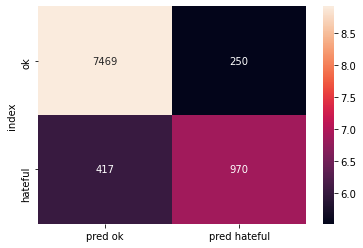

In [69]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(
    confusion_matrix(df["labels"], df["context_pred"])
)

cm.columns = ["pred ok", "pred hateful"]

cm["index"] = ["ok", "hateful"]

cm.set_index("index", inplace=True)

normalized = np.log(1+cm)
#normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)
sns.heatmap(normalized, annot=cm, fmt="")

<AxesSubplot:ylabel='index'>

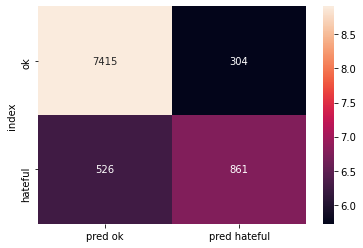

In [70]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(
    confusion_matrix(df["labels"], df["no_context_pred"])
)

cm.columns = ["pred ok", "pred hateful"]

cm["index"] = ["ok", "hateful"]

cm.set_index("index", inplace=True)

normalized = np.log(1+cm)
#normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)
sns.heatmap(normalized, annot=cm, fmt="")

## Errors

In [72]:
df["predicted"] = df["context_pred"] > 0


In [74]:
false_negatives = df.loc[((~df["predicted"]) & (df["labels"])) != 0]

false_positives = df.loc[((df["predicted"]) & (~df["labels"])) != 0]

columns = ["text", "context", "tokenized_text"] + extended_hate_categories
false_negatives = false_negatives[columns]
false_positives = false_positives[columns]

In [77]:
false_negatives.sample(10)

text  \
id                                                                                                                                                                                                                                                                                        
349815                                                                                                                                                                          [USER] Y si dejamos de comprar " Made in china" y se vuelven a morir de hambre como en la √©poca de Mao?   
404668  [USER] Van a solo darle uso para aspirar cocaina. Una investigaci√≥n analiz√≥ que los billetes de circulaci√≥n que hoy ten√©s en tu billetera, contienen cocaina entre las fibras del papel moneda. No s√≥lo ac√°, en el mundo entero.[EMOJI] hombre con la mano en la frente [EMOJI]   
356897                                                                                                                                                                                                                                                                  [USER] La resen   
337642          [USER] Los primeros en aprender de sus errores deben ser Uds, nosotros jam√°s asimilamos en nuestra cultura, las atrocidades q Uds hacen con la fauna silvestre, no admitimos esos comportamientos, Uds contagiaron al mundo y hoy quieren dar consejos, primero CAMBIEN   
344239                                                                                                                                                                                                                                  [USER] Caminemos a Luj√°n para apoyar este santo   
372322                                                                                                                                                                                                                                                           [USER] Panz√≥n pelotudo   
393954                                                                                                                                                                                                     [USER] De sentarse en el pinocho a comer moluscos! Ni vos te la crees Duggan   
367467                                                                                                                                                                                            [USER] Siempre los chinos metidos en cada quilombo posible ... son como langostas ...   
359910                                                                                                                                                                                                                          [USER] Qu√© pena lo tuyo pibe! Cada vez m√°s derechoso...   
369899                                                                                     [USER] Que feo pensar que ac√° los bolivianos hasta planes sociales tiene y disfrutan de nuestro sistema de salud y educativo cada vez me convenzo m√°s que los arg somos demasiados generosos   

                                                                                                                                          context  \
id                                                                                                                                                  
349815                                                                       China: Xi Jinping llam√≥ a sus soldados a "prepararse para la guerra"   
404668                                  Senadores kirchneristas proponen que la mitad de los nuevos billetes de $1.000 tengan la cara de Maradona   
356897                                                            R√≠o Gallegos: una mujer destruy√≥ a palazos el auto de alta gama de su ex pareja   
337642            Wuhan celebra el fin de la cuarentena por el coronavirus con un mensaje para el resto del mundo: "

In [76]:
false_positives.sample(10)

text  \
id                                                                                                                                                                                                                                                                                                         
370092                                                                                                                                                                                               usuario Hacer lo que uno quiere se llama LIBERTAD no feminismo...que conceptos equivocados ten√©s...   
404745                                                                                                                                                                                                 usuario Si el que va a tener al beb√© es el que parece hombre, entonces no es trans , es travesti.   
339575                                                                                                                                                                                                                                                                          usuario UN CHINO NEGRO !   
352492                                                                                                                                                                                                                  usuario Que pa√≠s del orto. Ni robar en paz se puede ahora que lo tirotean a uno.   
384426  usuario Aysa es de la Naci√≥n... Si quieren estos CHORROS K QUE Aysa sea solo responsabilidad de la Ciudad.  Que Cada Provincia haga su planta Potabilizadora y distribuci√≥n . L9S CHORROS KURCHNERISTAS COMO NO SABEN GESTIONAR Y SOLO SABEN ROBAR DINERO DE LOS IMPUESTOS.  KULPAN A LOS DEMAS.   
402742                                                                                                                                                                                                                                               usuario SSHH.... HAY M√ÅS MUGRE ADENTRO Q AFUERA....   
400542                                                                                                                                                                                                                                                               usuario Seguramente la queria poner   
388725                                                                                                                                                                                                                                                                               usuario D√≥nalo papu   
341477                                                                                                                                                                                                                                                      usuario No son clientes, son prostituyentes!   
372330                                                                                                                                                                                                                                               usuario Ojala lo culeen en Brasil pardo olor a culo   

                                                                                                                                                context  \
id                                                                                                                                                        
370092                                           Florencia Pe√±a: ‚ÄúNo debe ser f√°cil ser hijo m√≠o, pero como mam√° estoy a la altura de la circunstancia‚Äù   
404745                                                                    Historia: Franco, un hombre trans, tendr√° un hijo con Hannah, una mujer trans   
339575                                                E

Veamos en qu√© categor√≠as falla m√°s


In [71]:
hateful = dev_df[dev_df["labels"] == 1]

std = hateful[extended_hate_categories].std()
(false_negatives[extended_hate_categories].mean() - hateful[extended_hate_categories].mean()) / std

CALLS        -0.16003
WOMEN         0.18792
LGBTI         0.07151
RACISM       -0.02460
CLASS         0.07151
POLITICS     -0.01147
DISABLED      0.03928
APPEARANCE   -0.14719
CRIMINAL     -0.17322
dtype: float64

A ver, de lo que vemos:

- Hay sustancialmente m√°s falsos negativos sobre la categor√≠a mujer => veamos ah√≠!
- Hay muy pocos de apariencia

In [72]:
(false_positives[extended_hate_categories].mean() - hateful[extended_hate_categories].mean()) / std

CALLS        -0.47331
WOMEN        -0.43051
LGBTI        -0.32420
RACISM       -0.66105
CLASS        -0.32420
POLITICS     -0.43754
DISABLED     -0.25542
APPEARANCE   -0.49147
CRIMINAL     -0.46874
dtype: float64

Con **falsos positivos** tenemos:

- 